# Lab 1

## Question 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
# import statsmodels.api as sm
import powerlaw
import scipy.stats as stats

### Dataset

Perform general statistical analyses on the datasets.  Are the results expected ?Perform some sanity checks on the data.  Is the dataset free of visible problems ?

In [2]:
def get_all_files(directory):
    files = [f for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f))]
    return files

In [3]:
directory_path = "C:/Users/Hinnovis/Desktop/3A/CS/DHF/Data-SG/Data/SG"
files = get_all_files(directory_path)

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'C:/Users/Hinnovis/Desktop/3A/CS/DHF/Data-SG/Data/SG'

In [ ]:
# files = get_all_files(os.path.join('data', 'SG'))

dfs = []

for file in files:
    df_small = pd.read_csv(os.path.join(directory_path, file), index_col = 0)
    dfs.append(df_small)
    break                   # < ----------------- remove this line to read all files
df = pd.concat(dfs)
df['ets'] = pd.to_datetime(df['ets'], format='%Y%m%d:%H:%M:%S.%f')
df.head()

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
0,2017-01-17 09:01:00.270164,A,45610,1400,B,46010,1066,46085,1445
1,2017-01-17 09:01:00.312121,A,46485,700,S,46010,1066,46085,1445
2,2017-01-17 09:01:00.358162,A,46000,124,B,46010,1066,46085,1445
3,2017-01-17 09:01:00.359972,A,45950,182,B,46010,1066,46085,1445
4,2017-01-17 09:01:00.360001,A,45970,22,B,46010,1066,46085,1445


- A: add limit order
- T: Trade (takes the best price)
- M: Modification
- C: Cancel

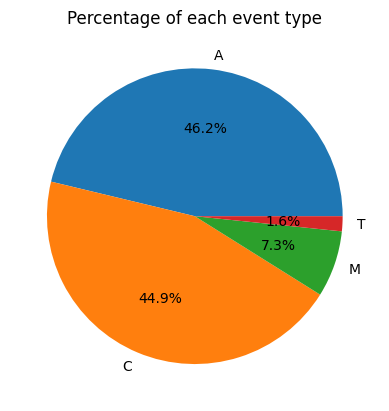

In [ ]:
plt.title("Percentage of each event type")
plt.pie(df['etype'].value_counts() / len(df), labels=df['etype'].value_counts().index, autopct='%1.1f%%')
plt.show()

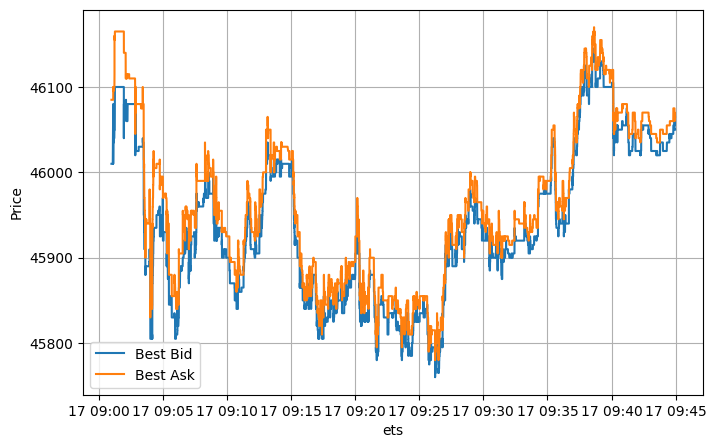

In [ ]:
df_2 = df.copy()
df_2.set_index('ets', inplace=True)
df_2.sort_index(inplace=True, ascending=True)

start_date = '2017-01-17 09:01:00.270164'
end_date = '2017-01-17 09:45:00.00'

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_2[start_date:end_date], x='ets', y='bp0', label="Best Bid")
sns.lineplot(data=df_2[start_date:end_date], x='ets', y='ap0', label="Best Ask")
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

#### Trade Volumes

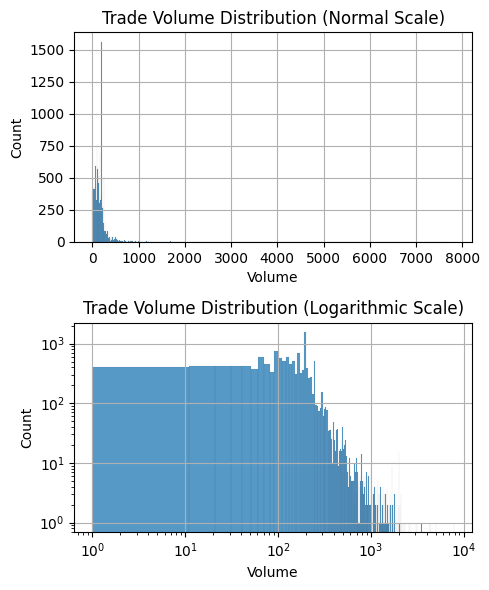

In [ ]:
# Filter the DataFrame for trades
df_trades = df[df['etype'] == 'T'].copy()

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(5, 6))

# Normal scale plot
sns.histplot(df_trades, x='eqty', kde=False, ax=axes[0])
axes[0].set_title('Trade Volume Distribution (Normal Scale)')
axes[0].set_xlabel('Volume')
axes[0].grid()

# Logarithmic scale plot
sns.histplot(df_trades, x='eqty', kde=False, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel('Volume')
axes[1].set_title('Trade Volume Distribution (Logarithmic Scale)')
axes[1].grid()

plt.tight_layout()
plt.show()

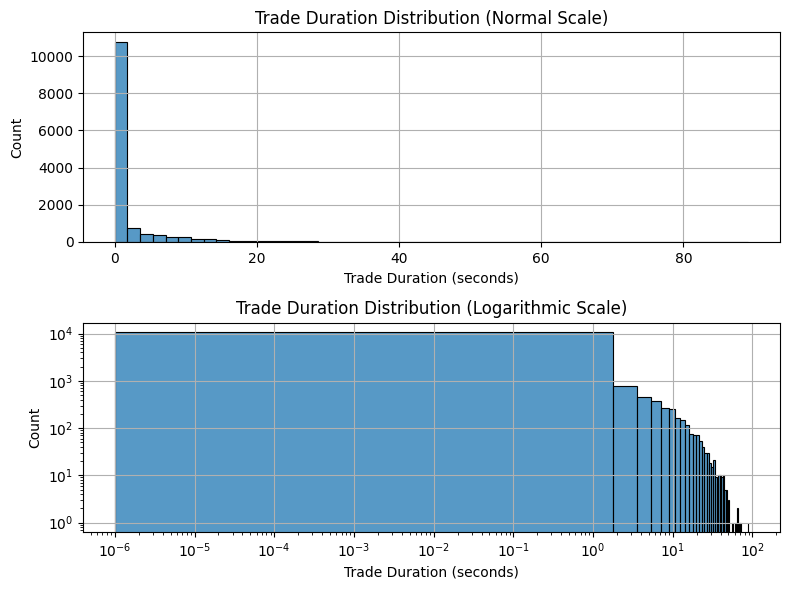

In [ ]:
df_trades = df[df['etype'] == 'T'].copy()
df_trades['trade_duration'] = df_trades['ets'].diff().dt.total_seconds()
df_trades = df_trades.iloc[1:]

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

sns.histplot(df_trades, x='trade_duration', kde=False, bins=50, ax=axes[0])
axes[0].set_title('Trade Duration Distribution (Normal Scale)')
axes[0].set_xlabel('Trade Duration (seconds)')
axes[0].grid()

sns.histplot(df_trades, x='trade_duration', kde=False, bins=50, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel('Trade Duration (seconds)')
axes[1].set_title('Trade Duration Distribution (Logarithmic Scale)')
axes[1].grid()

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency (log scale)')

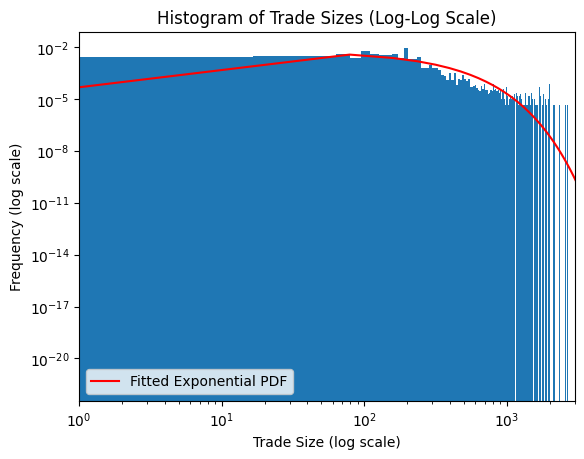

In [ ]:
# Fit an exponential distribution to the data
loc, scale = stats.expon.fit(df_trades['eqty'])

# Create a finer grid for plotting the fitted PDF
x_fit = np.linspace(0, np.max(df_trades['eqty']), 100)
y_fit = stats.expon.pdf(x_fit, loc=loc, scale=scale)

# Plot the original data and the fitted PDF
plt.hist(df_trades["eqty"], bins=500, density=True)
plt.plot(x_fit, y_fit, 'r-', label='Fitted Exponential PDF')
plt.legend()
plt.xlim(1, 3000)
plt.xscale('log')
plt.yscale('log')
plt.title('Histogram of Trade Sizes (Log-Log Scale)')
plt.xlabel('Trade Size (log scale)')
plt.ylabel('Frequency (log scale)')

Calculating best minimal value for power law fit


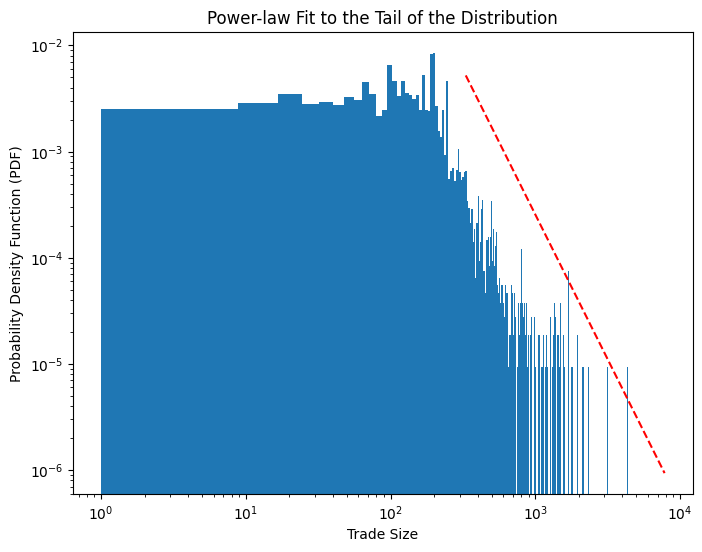

Power-law alpha: 2.728016118460718
Power-law xmin: 331.0


In [ ]:
# Use the powerlaw package to fit the data
fit = powerlaw.Fit(df_trades["eqty"])

plt.figure(figsize=(8, 6))

alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
plt.hist(df_trades["eqty"], bins=1000, density=True)
fit.power_law.plot_pdf(color='r', linestyle='--')

plt.xlabel('Trade Size')
plt.ylabel('Probability Density Function (PDF)')
plt.title('Power-law Fit to the Tail of the Distribution')
plt.show()

# Print the estimated parameters
print(f"Power-law alpha: {alpha}")
print(f"Power-law xmin: {xmin}")

#### Trading activity and volatility

### Mid-Price and Weighted Mid-Price Visualization

The mid-price is defined as :

$$Mid\text{-}Price = \frac{a(t) + b(t)}{2}$$

The **weighted mid-price** is defined as:

$$W_{mid-price} = \frac{a(t)q^B(t) + b(t)q^A(t)}{q^B(t) + q^A(t)}$$

In [ ]:
# bp0, bq0,	ap0, aq0
# best bid price, best bid quantity, best ask price, best ask quantity

df['mid_price'] = (df['bp0'] + df['ap0']) / 2

df['weighted_mid_price'] = ((df['bp0'] * df['aq0']) + (df['ap0'] * df['bq0'])) / (df['bq0'] + df['aq0'])

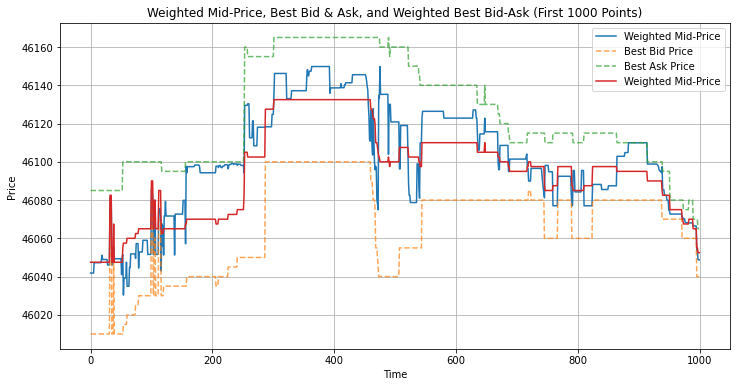

In [ ]:
df_subset = df.iloc[:1000]

plt.figure(figsize=(12, 6))
df_subset['weighted_mid_price'].plot(label="Weighted Mid-Price", linestyle='-', linewidth=1.5)
df_subset['bp0'].plot(label="Best Bid Price", linestyle='--', alpha=0.7)
df_subset['ap0'].plot(label="Best Ask Price", linestyle='--', alpha=0.7)
df_subset['mid_price'].plot(label="Weighted Mid-Price", linestyle='-', linewidth=1.5)

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Weighted Mid-Price, Best Bid & Ask, and Weighted Best Bid-Ask (First 1000 Points)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df['tick_size_bid'] = df['bp0'].diff().abs()
df['tick_size_ask'] = df['ap0'].diff().abs()

tick_sizes = pd.concat([df['tick_size_bid'], df['tick_size_ask']]).replace(0, np.nan).dropna()

measured_tick_size = tick_sizes.min()
print(f'the smallest tick size occuring on the dataset is in line with the official tick size : {measured_tick_size} for stocks between 9.99 and 50 Euros as outlined in the course')

the smallest tick size occuring on the dataset is in line with the official tick size : 5.0 for stocks between 9.99 and 50 Euros as outlined in the course


### Question 4

In [ ]:
# pip install -U seaborn --user
# ! pip install seaborn==0.13.2 --user
! pip install seaborn --upgrade

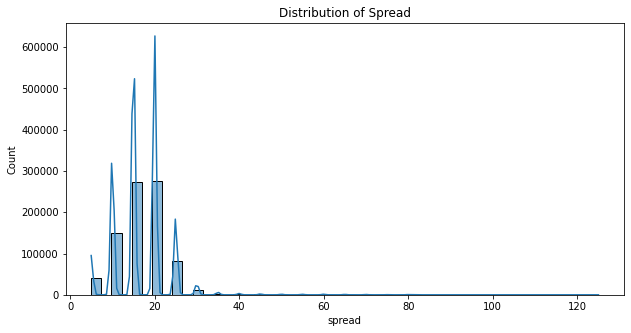

In [ ]:
df['spread'] = df['ap0'] - df['bp0']
plt.figure(figsize=(10, 5))
sns.histplot(df['spread'], bins=50, kde=True)
plt.title("Distribution of Spread")
plt.show()


the distribution indicates a large tick stock, because it is less continuous

In [ ]:
spread_counts_cum_time.head()

spread
5     0.997179
10    0.995233
15    0.996356
20    0.999726
25    0.996362
Name: ets, dtype: float64

In [ ]:
spread_counts.head()

20    0.327784
15    0.323497
10    0.179281
25    0.097077
5     0.048897
Name: spread, dtype: float64

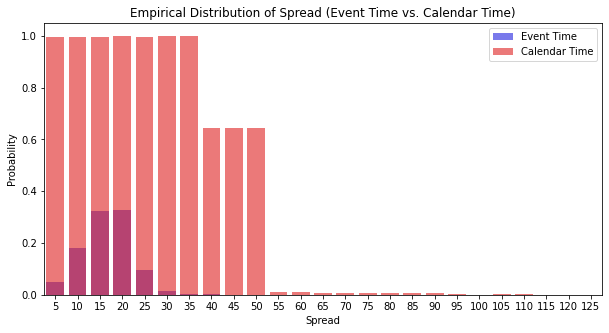

In [ ]:
# Event Time vs Calendar Time Distribution
spread_counts = df['spread'].value_counts(normalize=True)
spread_counts_cum_time = (df.groupby('spread')['ets'].diff().dt.total_seconds().groupby(df['spread']).sum()) / df['ets'].diff().dt.total_seconds().sum()

plt.figure(figsize=(10, 5))
sns.barplot(x=spread_counts.index, y=spread_counts.values, color='blue', alpha=0.6, label="Event Time")
sns.barplot(x=spread_counts_cum_time.index, y=spread_counts_cum_time.values, color='red', alpha=0.6, label="Calendar Time")
plt.legend()
plt.xlabel("Spread")
plt.ylabel("Probability")
plt.title("Empirical Distribution of Spread (Event Time vs. Calendar Time)")
plt.show()

the calendar distribution shows that narrower spreads persist longer

### Question 5

In [ ]:
df_ = df.copy()
df_ = df_.drop_duplicates(subset=['ets'])
df_calendar = df_.set_index('ets').resample('1S').ffill().reset_index()

In [ ]:
df_calendar.head()

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,spread,mid_price,weighted_mid_price,log_return_1,log_return_10,log_return_100
0,2017-01-17 09:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-17 09:01:01,A,45970.0,22.0,B,46010.0,1066.0,46085.0,1445.0,75.0,46047.5,46041.839904,0.0,NaN,NaN
2,2017-01-17 09:01:02,A,46475.0,700.0,S,46010.0,1427.0,46085.0,1445.0,75.0,46047.5,46047.264972,0.0,0.0,NaN
3,2017-01-17 09:01:03,C,46010.0,200.0,B,46010.0,1559.0,46085.0,1445.0,75.0,46047.5,46048.923103,0.0,0.0,NaN
4,2017-01-17 09:01:04,A,45975.0,200.0,B,46010.0,1559.0,46085.0,1445.0,75.0,46047.5,46048.923103,0.0,0.0,NaN


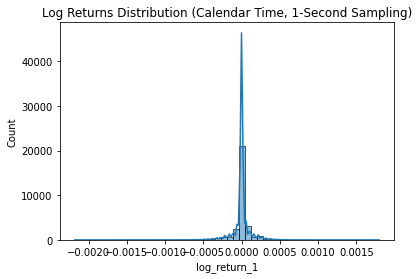

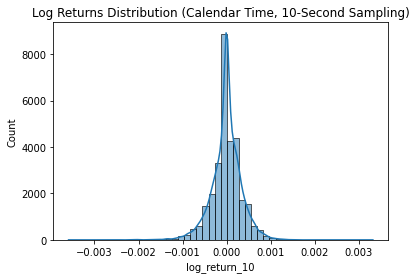

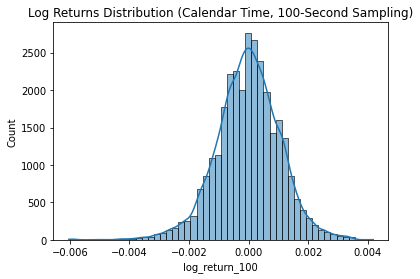

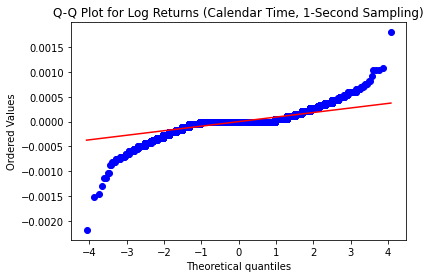

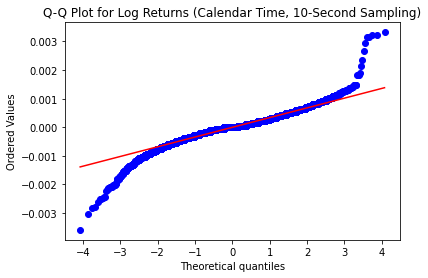

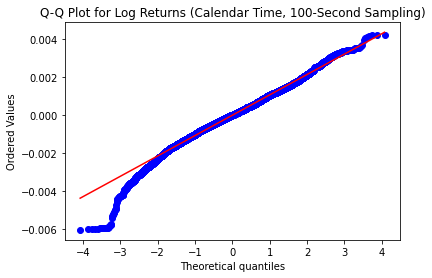

In [ ]:
# in calendar time frequencies


for freq in [1, 10, 100]:
    df_calendar[f'log_return_{freq}'] = np.log(df_calendar['mid_price']).diff(freq)
    sns.histplot(df_calendar[f'log_return_{freq}'].dropna(), kde=True, bins=50)
    plt.title(f'Log Returns Distribution (Calendar Time, {freq}-Second Sampling)')
    plt.show()

# Check Gaussian assumption
for freq in [1, 10, 100]:
    stats.probplot(df_calendar[f'log_return_{freq}'].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for Log Returns (Calendar Time, {freq}-Second Sampling)')
    plt.show()

The gaussian property is satisfied judging by the QQ plots

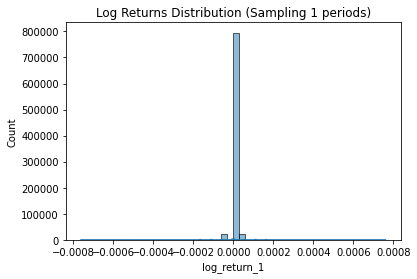

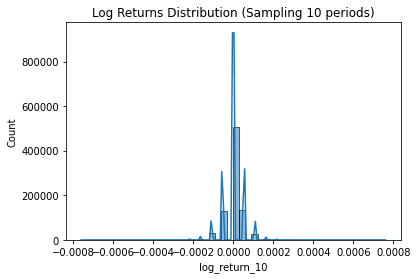

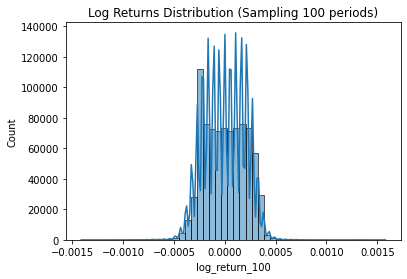

In [ ]:
# in event time frequencies
for freq in [1, 10, 100]:
    df[f'log_return_{freq}'] = np.log(df['mid_price']).diff(freq)
    sns.histplot(df[f'log_return_{freq}'].dropna(), kde=True, bins=50)
    plt.title(f'Log Returns Distribution (Sampling {freq} periods)')
    plt.show()

The gaussian property is more apparent when using calendar time scale

### Question 6

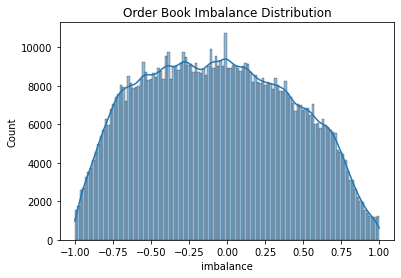

In [ ]:
# 6. Imbalance Analysis
df['imbalance'] = (df['bq0'] - df['aq0']) / (df['bq0'] + df['aq0'])
sns.histplot(df['imbalance'], kde=True)
plt.title("Order Book Imbalance Distribution")
plt.show()

In [ ]:
# Correlation between imbalance and mid-price change
df['mid_price_change'] = df['mid_price'].diff().shift(-1)
correlation = df[['imbalance', 'mid_price_change']].corr().iloc[0, 1]
print(f"Correlation between imbalance and mid-price change: {correlation}")

Correlation between imbalance and mid-price change: 0.17057476308185754


low correlation confirms that traders cannot use imbalance as a signal.

### Question 7

In [ ]:
# Autocorrelation of trade signs
df['trade_sign'] = np.sign(df['mid_price'].diff())
pd.plotting.autocorrelation_plot(df['trade_sign'].dropna())
plt.title("Autocorrelation of Trade Signs")
plt.show()

In [ ]:

# Autocorrelation of price pressure events
df['price_pressure'] = np.sign(df['bp0'].diff().fillna(0) + df['ap0'].diff().fillna(0))
pd.plotting.autocorrelation_plot(df['price_pressure'].dropna())
plt.title("Autocorrelation of Price Pressure Events")
plt.show()

# Autocorrelation based on impacted side of the order book
df['impacted_side'] = np.sign(df['bq0'].diff().fillna(0) - df['aq0'].diff().fillna(0))
pd.plotting.autocorrelation_plot(df['impacted_side'].dropna())
plt.title("Autocorrelation of Impacted Side of the Order Book")
plt.show()
